In [93]:
import numpy as np
import struct, math
from array import array
import matplotlib.pyplot as plt
import numpy.matlib as mat
%matplotlib inline

def load(file_img, file_label, N):
    with open(file_label, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        labels = array("B", file.read())

    with open(file_img, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        image_data = array("B", file.read())
    images = []
    for i in range(N):
        images.append([0] * rows * cols)
    for i in range(N):
        images[i][:] = image_data[i * rows * cols:(i + 1) * rows * cols]
    images = np.array(images)
    images = np.insert(images, 0, np.ones(N),1)
    #print(images)
    #print(images.shape)
    labels = np.array(labels[:N])
    return images, labels

In [145]:
def div0( a, b ):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide( a, b )
        c[ ~ np.isfinite( c )] = 0  # -inf inf NaN
    return c

def net(x,w):
    #print(x.shape)
    #print(w.shape)
    res = np.dot(x,w)
    return res
def one_hot(y):
    labels = np.zeros((50000,10))
    for i in range(len(train_labels)):
        labels[i][int(train_labels[i])] = 1
    return  labels

def  getPred(p):
    return [np.argmax(row) for row in p]

def  getPred_sto(p):
    return np.argmax(p)

def gradient(x,y):
    return np.dot(x.T, y)

def get_error(pred,target):
    error = 0
    for p,t in zip(pred,target):
        if p != t:
            error +=1
    return float(error)/len(target)


def sigmoid_func(x):   
    return 1 / (1 + math.exp(-x))

def sigmoid(z, der = False):
    #z -= np.max(z)
    if der == True: 
        return z * (1 - z)
    f = np.vectorize(sigmoid_func)
    return f(z)

def tanh_func(x):
    return (np.exp(x).T - np.exp(-x).T)/(np.exp(x).T + np.exp(-x).T)
def tanh(z,der = False):
    #z -= np.max(z)
    if der == True: 
        return 1 - np.power(z,2)
    f = np.vectorize(tanh_func)
    return f(z)
def ReLU(z,der = False):
    #z -= np.max(z)
    if der == True: 
        z[z > 0] = 1
        z[z<=0] = 0
        return z
    return z.clip(0)

def softmax(z,der = False):
    #print("Z:", z)
    #print("MAX: ", np.max(z))
    z -= np.max(z)
    return (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
def softmax_sto(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z))).T
    return sm
def cross_entropy(t,w,x,label,WHO):
    E = 0
    net_out = net(x,w)
    if label == "IH":
        hid = sigmoid(net_out)
        hid = np.insert(hid, 0, np.ones(50000),1)
        y = softmax(net(hid,WHO))
    else:
        y = softmax(net_out) 
    #if i == 0 and j == 0:
        #print(y.shape)
    #E += t[i][j]*np.log(y[i][j]) + ((1-t[i][j])*np.log(1-y[i][j]))
    #E += (t*np.log(y) + ((1-t)*np.log(1-y))).sum()
    E += (t*np.log(y)).sum()
    return E

def gradient_check(t,w,x,label,WHO):
    row,col = w.shape
    gradApprox = np.zeros((row,col))
    e = 1e-2
    for i in range(row):
        for j in range(col):
            wPlus = w.copy()
            wPlus[i][j] +=  e
            wMinus = w.copy()
            wMinus[i][j] -= e
            #cross_entropy as in error function
            gradApprox[i][j] = (cross_entropy(t,wPlus,x,label,WHO)-cross_entropy(t,wMinus,x,label,WHO))/(2*e)
    return gradApprox

def update_weights(W,alpha,delta,layer, delta_weight = None,lamb = None, gamma = None):
    grad = gradient(layer, delta)
    if grad.shape != W.shape:
        grad = grad[:,1:]
    if lamb != None : 
        #return W + alpha*gradient(layer,delta) + reg * 2 * W
        reg = lamb  * W.sum()
        return W + alpha*(grad - lamb)
    if gamma != None: 
        return W + alpha*grad + gamma *(delta_weight)

    return W + alpha *grad

def diff_weights(W,old_weight,t):
    if t == 0:
        return np.zeros((W.shape)), W
    return (W-old_weight),W

def print_grad(delta,gradApprox):
    print("average difference: ",((delta)-(gradApprox)).mean()/10)
    for row1,row2 in zip(delta,gradApprox):
        if row1[0] != 0.0:
            print("backprop: ",(row1[:4]))
            print("gradient: ",(row2[:4]))
            print("------------------------------------------------------------------------------")


In [146]:
train_data, train_labels = load('train-images-idx3-ubyte', 'train-labels-idx1-ubyte', 60000)
test_data, test_labels = load('t10k-images-idx3-ubyte','t10k-labels-idx1-ubyte',7000)

row, size = np.shape(train_data)
mean_list = [np.mean(train_data[:, i]) for i in range(size)]
std_list = [np.std(train_data[:, i]) for i in range(size)]

mean_matrix = mat.repmat(mean_list, row, 1)
std_matrix = mat.repmat(std_list, row, 1)

train_mean = (train_data - mean_matrix)
train_data = div0(train_mean,std_matrix)


validation = train_data[50000:,:]
validation_labels = train_labels[50000:]
train_data = train_data[:50000,:]
train_labels = train_labels[:50000]

labels = one_hot(train_labels)

0.8983
87


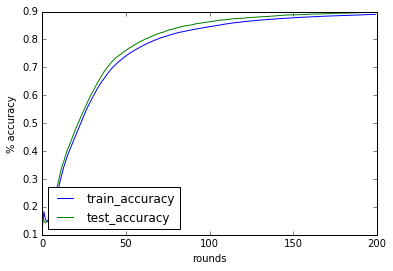

In [199]:
alpha = 1e-5
e = 1e-2
rounds = 200
old_WIH = np.zeros((785,10))
old_WHO = np.zeros((11,10))
WIH = np.random.normal(0.0,1/np.sqrt(785),(785,10))
WHO = np.random.normal(0.0,1/np.sqrt(785),(11,10))
best_WIH = np.zeros((785,10))
best_WHO = np.zeros((161,10))
test_errors = []
train_errors = []
best_round = []
best_er = 1.0
wd = 0.001
m = 0.9
for t in range(rounds):
    ###TRAINING SET
    ##To change activation function: replace sigmoid when assigning hidden layers
    hidden = sigmoid(net(train_data, WIH))
    hidden = np.insert(hidden, 0, np.ones(50000),1)
    
    out = softmax(net(hidden,WHO))
    out_delta = (labels - out)   
    
    ##getting the error
    pred_train = getPred(out)
    er_train = get_error(pred_train,train_labels)
    train_errors.append(1-er_train)
    hidden_delta = (out_delta.dot(WHO.T))*sigmoid(hidden,True)
    
    #Gettings the numeric approximation for the gradient: uncomment following line
    #gradApprox = gradient_check(labels,WHO,hidden,"",WHO)
    #print_grad(out_delta,gradApprox)
    
    ##Calculate difference in weight for momemtum: uncomment following lines
    #delta_WHO, old_WHO = diff_weights(WHO,old_WHO,t)
    #delta_WIH, old_WIH = diff_weights(WIH,old_WIH,t)
    
    ##Updating weights
    WHO = update_weights(WHO, alpha, out_delta,hidden)
    WIH = update_weights(WIH, alpha, hidden_delta,train_data)
    
    ###TESTING SET
    hidden = sigmoid(net(validation, WIH))
    hidden = np.insert(hidden, 0, np.ones(10000),1)
    out = softmax(net(hidden,WHO))
    
    ##getting the error
    pred = getPred(out)
    er = get_error(pred,validation_labels)
    if er < best_er: 
        best_WIH = WIH
        best_WHO = WHO
        best_er = er
    if (1-er) > 0.85: 
        best_round.append(t)
    test_errors.append(1-er)
print(1-best_er)
if len(best_round) >0: 
    print(best_round[0])
plt.plot(train_errors)
plt.plot(test_errors)
plt.ylabel('% accuracy')
plt.xlabel('rounds')
plt.legend(['train_accuracy', 'test_accuracy'], loc='lower left')
pyplot.show()


In [ ]:
##FOR 2 HIDDEN LAYERS
alpha = 1e-4
e = 1e-2
rounds = 200
old_WIH = np.zeros((785,100))
old_WHO = np.zeros((101,10))
WIH = np.random.normal(0.0,1/np.sqrt(785),(785,100))
WM = np.random.normal(0.0,1/np.sqrt(785),(101,100))
WHO = np.random.normal(0.0,1/np.sqrt(785),(101,10))
best_WIH = np.zeros((785,100))
best_WHO = np.zeros((101,10))
test_errors = []
train_errors = []
best_round = []
best_er = 1.0
wd = 0.001
m = 0.9
for t in range(rounds):
    #hidden_delta = (hidden*(1-hidden)).dot(WHO)
    
    #WIH += alpha * (train_data.T.dot(hidden_delta))
    #grad = (-1)*gradient(train_data,(labels-probs)
    #w = w - (alpha* grad)
    
    ###TRAINING SET
    ##To change activation function: replace sigmoid when assigning hidden layers
    hidden = sigmoid(net(train_data, WIH))
    hidden = np.insert(hidden, 0, np.ones(50000),1)
    
    mid = sigmoid(net(hidden,WM))
    mid = np.insert(mid, 0, np.ones(50000),1)
    
    #out = softmax(net(hidden,WHO))
    out = softmax(net(mid,WHO))
    out_delta = (labels - out)   
    
    ##getting the error
    pred_train = getPred(out)
    er_train = get_error(pred_train,train_labels)
    train_errors.append(1-er_train)
    
    #
    mid_delta = (out_delta.dot(WHO.T))*sigmoid(mid,True)
    #temp = (out_delta.dot(WHO.T))*sigmoid(mid,True) 
    mid_delta = mid_delta[:,1:]
    hidden_delta = (mid_delta.dot(WM.T))*sigmoid(hidden,True)
    
    #Gettings the numeric approximation for the gradient: uncomment following line
    #gradApprox = gradient_check(labels,WHO,hidden,"",WHO)
    #print_grad(out_delta,gradApprox)
    
    ##Calculate difference in weight for momemtum: uncomment following lines
    #delta_WHO, old_WHO = diff_weights(WHO,old_WHO,t)
    #delta_WIH, old_WIH = diff_weights(WIH,old_WIH,t)
    
    ##Updating weights
    WHO = update_weights(WHO, alpha, out_delta,mid)
    #
    WM = update_weights(WM,alpha,mid_delta,hidden)
    WIH = update_weights(WIH, alpha, hidden_delta,train_data)
    
    ###TESTING SET
    hidden = sigmoid(net(validation, WIH))
    hidden = np.insert(hidden, 0, np.ones(10000),1)
    
    mid = sigmoid(net(hidden,WM))
    mid = np.insert(mid, 0, np.ones(10000),1)
    
    out = softmax(net(mid,WHO))
    
    ##getting the error
    pred = getPred(out)
    er = get_error(pred,validation_labels)
    if er < best_er: 
        best_WIH = WIH
        best_WHO = WHO
        best_er = er
    if (1-er) > 0.85: 
        best_round.append(t)
    test_errors.append(1-er)
print(1-best_er)
if len(best_round) >0: 
    print(best_round[0])
plt.plot(train_errors)
plt.plot(test_errors)
plt.ylabel('% accuracy')
plt.xlabel('rounds')
plt.legend(['train_accuracy', 'test_accuracy'], loc='lower right')
pyplot.show()